In [1]:
from datetime import datetime as dt
from glob import glob
import json
import pandas as pd
import numpy as np

In [2]:
data_list = []

for f_name in glob('C:/Users/evgen/HSE/Coursework/results/*.json'):
    
    with open(f_name, 'r', encoding='utf-8') as f:
        data = json.loads(f.read())   

        data_dict = {}
        
        num_of_goods = int(data['condition']['ordersize']) 
        
        # ОКПД2 (вида XX, т.е. до класса) - Количество наименований кодов
        for i in range(num_of_goods): 
            try:
                if data['products'][i]['options']['okpd2'][0]['label'][:2] in ['01','10']:
                    if  data['products'][i]['options']['okpd2'][0]['label'][:2] not in data_dict:
                        data_dict[data['products'][i]['options']['okpd2'][0]['label'][:2]] = 1
                    else:
                        data_dict[data['products'][i]['options']['okpd2'][0]['label'][:2]] += 1
                else:
                    if '0kpd2_general' not in data_dict:
                        data_dict['0kpd2_general'] = 1
                    else:
                        data_dict['0kpd2_general'] += 1
            except: 
                pass 
            
        # Единицы измерения - число
        for i in range(num_of_goods): 
            try:
                qty = data['products'][i]['qty'].replace(',', '.')
                qty = float(qty)
                if data['products'][i]['options']['OKEI'][0]['label'] in ['Килограмм', 'Литр;^кубический дециметр', 'Штука']:
                    unit = 'unit_' + data['products'][i]['options']['OKEI'][0]['label']
                    if unit not in data_dict:
                        data_dict[unit] = qty
                    else:
                        data_dict[unit] += qty
                else:
                    if 'unit_general' not in data_dict:
                        data_dict['unit_general'] = qty
                    else:
                        data_dict['unit_general'] += qty
            except:
                pass
        
        # Начальная цена закупки - число
        try: 
            data_dict['startfinalprice'] = float(data['condition']['startfinalprice'])
        except: 
            data_dict['startfinalprice'] = -1
        
        # тип учреждения - 0/1
        try:
            if data['customer']['organization']['details']['type_name'] in ['бюджетное учреждение','казенное учреждение', 
                                                                            'орган гос.власти']:
                organization = 'org_' + data['customer']['organization']['details']['type_name']
                data_dict[organization] = 1
            else:    
                data_dict['org_general'] = 1
        except: 
            data_dict['org_general'] = -1 # пропущенное значение
            
            
        # Регион поставки товара - 0/1   
        try:
            if 'Ульяновская' in data['delivery']['address']['region']:
                data_dict['region_0'] = 1
            elif 'Москва' in data['delivery']['address']['region']:
                data_dict['region_1'] = 1
            elif ('Московская' in data['delivery']['address']['region']) or ('Орловская' in data['delivery']['address']['region']):
                    data_dict['region_2'] = 1
            elif ('Ростовская' in data['delivery']['address']['region']) or ('Хабаровский' in data['delivery']['address']['region'])\
                or ('Приморский' in data['delivery']['address']['region']) or ('Краснодарский' in data['delivery']['address']['region']):
                    data_dict['region_3'] = 1   
            elif ('Мордовия' in data['delivery']['address']['region']) or ('Марий Эл' in data['delivery']['address']['region'])\
                or ('Воронежская' in data['delivery']['address']['region']) or ('Красноярский' in data['delivery']['address']['region'])\
                or ('Крым' in data['delivery']['address']['region']):
                    data_dict['region_4'] = 1            
            elif ('Татарстан' in data['delivery']['address']['region']) or ('Саратовская' in data['delivery']['address']['region'])\
                or ('Оренбургская' in data['delivery']['address']['region']) or ('Нижегородская' in data['delivery']['address']['region'])\
                or ('Санкт-Петербург' in data['delivery']['address']['region'])  or ('Пермский' in data['delivery']['address']['region']):
                    data_dict['region_5'] = 1  
            elif ('Удмуртская' in data['delivery']['address']['region']) or ('Кемеровская' in data['delivery']['address']['region'])\
                or ('Тульская' in data['delivery']['address']['region']) or ('Новосибирская' in data['delivery']['address']['region'])\
                or ('Омская' in data['delivery']['address']['region'])  or ('Алтайский' in data['delivery']['address']['region'])\
                or ('Ставропольский' in data['delivery']['address']['region']) or ('Калужская' in data['delivery']['address']['region'])\
                or ('Волгоградская' in data['delivery']['address']['region']) or ('Башкортостан' in data['delivery']['address']['region'])\
                or ('Ивановская' in data['delivery']['address']['region'])  or ('Владимирская' in data['delivery']['address']['region'])\
                or ('Астраханская' in data['delivery']['address']['region']):
                    data_dict['region_6'] = 1 
            else: 
                data_dict['region_7'] = 1 
        except: 
            data_dict['region_7'] = -1 # пропущенное значение   
        
        # временная зона - 0/1
        try:       
            if data['customer']['organization']['details']['time_zone_utc_offset'] in ['0','1','2','4','7']:
                time_zone = 'time_z_' + data['customer']['organization']['details']['time_zone_utc_offset']
                data_dict[time_zone] = 1
            elif data['customer']['organization']['details']['time_zone'] in ['0','1','2','4','7']:
                time_zone = 'time_z_' + data['customer']['organization']['details']['time_zone']
                data_dict[time_zone] = 1
            else:                
                data_dict['time_z_general'] = 1
        except: 
            data_dict['time_z_general'] = -1 # пропущенное значение
        
        # закупка в рамках Гособоронзаказа - 0/1
        try:
            data_dict['gosob_z'] = int(data['gosoboronzakaz']) 
        except: 
            data_dict['gosob_z'] = -1 # пропущенное значение
        
        # тип закупки - 0/1
        try:
            if data['condition']['ordertype'] in ['Закупка до 300 000 руб. (п.4 ст.93 Закона №44-ФЗ)',
                                                  'Закупка до 600 000 руб. (п.4 ч.1 ст.93 Закона №44-ФЗ)',
                                                  'Закупка до 600 000 руб. (п.5 ч.1 ст.93 Закона №44-ФЗ)']:
                purchase_type = data['condition']['ordertype']
                data_dict[purchase_type] = 1
            else:                   
                data_dict['Закупка_general'] = 1
        except: 
            data_dict['Закупка_general'] = -1 # пропущенное значение
        
        # продолжительность закупки в часах - 0/1
        try:
            if data['condition']['purchase_duration_hours'] == '2':
                data_dict['duration_2'] = 1
        except: 
            data_dict['duration_2'] = -1 # пропущенное значение
        
        # можно ли участвовать "недобросовестным поставщикам" - 0/1
        try:
            data_dict['unfair_suppl'] = int(data['disallowed_for_unfair_suppliers'])
        except: 
            data_dict['unfair_suppl'] = -1 # пропущенное значение
        
        # вид оплаты- 0/1
        try:
            type_of_pay = 'type_of_pay_' + data['condition']['payment']
            data_dict[type_of_pay] = 1
        except: 
            data_dict['type_of_pay_bank_account_payment'] = -1 # пропущенное значение
        
        # условия оплаты - 0/1
        try:
            payment_terms = 'payment_terms_' + data['condition']['payment_terms']
            data_dict[payment_terms] = 1
        except: 
            data_dict['payment_terms_deferred_payment'] = -1 # пропущенное значение
        
        # на сколько дней может быть отложен платеж - число
        try:
            data_dict['deadline_pay'] = int(data['condition']['payment_deadline_days'])
        except:
            data_dict['deadline_pay'] = 0
        
        # число месяца создания заявки - число
        try:
            m_day = int(data['created_at'][8:10])
            if m_day in [3, 6, 20]:
                data_dict['m_day_5'] = 1
            elif m_day in [10, 11, 17, 18, 19, 23, 25, 27, 28]: 
                data_dict['m_day_4'] = 1
            elif m_day in [2, 5, 13, 15, 21, 22, 24, 29]: 
                data_dict['m_day_3'] = 1
            elif m_day in [ 4, 16, 26]:
                data_dict['m_day_2'] = 1
            elif m_day in [7, 12, 13, 14, 30, 31]:
                data_dict['m_day_1'] = 1    
            else: 
                data_dict['m_day_0'] = 1
        except: 
            data_dict['m_day_5'] = -1 # пропущенное значение
        
        # день недели создания заявки - 0/1
        try:
            created_at_date = dt.strptime(data['created_at'][:10], "%Y-%m-%d")
            w_day = int(created_at_date.isoweekday())
            if w_day in [1,2,3]:
                data_dict['w_day_123'] = 1
            elif w_day==6 or w_day==7:
                data_dict['weekend'] = 1    
            else:
                w_day = 'w_day_' + str(w_day)
                data_dict[w_day] = 1
        except: 
            data_dict['w_day_123'] = -1 # пропущенное значение
        
        # час создания заявки - 0/1
        try:
            hour = int(data['created_at'][11:13])
            if hour in [7,8,9,10]:
                data_dict['h_6'] = 1
            elif hour in [11, 12]: 
                data_dict['h_5'] = 1                
            elif hour in [5, 6, 13]: 
                data_dict['h_4'] = 1
            elif hour in [4, 14, 15]: 
                data_dict['h_3'] = 1
            elif hour in [2, 3, 16]:
                data_dict['h_2'] = 1
            elif hour in [23, 0, 1, 17, 18, 19]:
                data_dict['h_1'] = 1
            else:    
                data_dict['h_0'] = 1
        except: 
            data_dict['h_6'] = -1 # пропущенное значение
        
        # число дней между датой создания заявки и планируемой датой заключения контракта - число
        try:
            planContractDate = dt.strptime(data['planContractDate'][:10], "%Y-%m-%d")
            data_dict['diff_cr_and_cont'] = int((planContractDate - created_at_date).days)
        except: 
            data_dict['diff_cr_and_cont'] = -1 # пропущенное значение

        # год регистрации учреждения - число
        start = 1989
        try:
            data_dict['reg_org_date'] = int(data['customer']['organization']['details']['registration_date'][:4]) - start 
        except: 
            data_dict['reg_org_date'] = -1 # пропущенное значение
        
        # ссылка на закупку
        try:
            data_dict['URL'] = data['URL'][33:40]
        except: 
            pass
    
        # ЦЕЛЕВЫЕ ПЕРЕМЕННЫЕ
        
        # Статус закупки
        try:
            if data['status'] not in ['CompletedWithoutWinner', 'canceled', 'order_terminated']:
                data_dict['status'] = 1
            else:
                data_dict['status'] = 0
        except: 
            data_dict['status'] = -1 # пропущенное значение 
        
        data_list.append(data_dict)

In [3]:
len(data_list)

9972

In [4]:
data = pd.DataFrame(data_list)
data

10  unit_Килограмм  startfinalprice  org_казенное учреждение  region_7  \
0     2.0             9.0           2865.0                      1.0       1.0   
1     1.0           500.0           3450.0                      1.0       NaN   
2     3.0           100.0          29200.0                      1.0       1.0   
3     1.0             NaN           9200.0                      NaN       NaN   
4     1.0             NaN          15300.0                      NaN       1.0   
...   ...             ...              ...                      ...       ...   
9967  NaN           218.0           7100.0                      1.0       1.0   
9968  5.0            53.0           9404.0                      1.0       1.0   
9969  1.0           200.0           2000.0                      1.0       NaN   
9970  3.0           172.0         146016.0                      1.0       NaN   
9971  1.0            49.0          24647.0                      1.0       NaN   

      time_z_0  gosob_z  Закупка до 300 000 руб. (п.4 ст.93 Закона №44-ФЗ)  \
0          1.0        1                                                1.0   
1          NaN        0                                                1.0   
2          NaN        0                                                1.0   
3          1.0        0                                                1.0   
4          1.0        0                                                1.0   
...        ...      ...                                                ...   
9967       1.0        0                                                1.0   
9968       1.0        0                                                1.0   
9969       1.0        0                                                1.0   
9970       1.0        0                                                NaN   
9971       1.0        1                                                1.0   

      duration_2  unfair_suppl  ...  m_day_5  w_day_5  m_day_3  weekend  \
0            1.0             0  ...      NaN      NaN      NaN      NaN   
1            1.0             0  ...      NaN      NaN      NaN      NaN   
2            1.0             0  ...      NaN      NaN      NaN      NaN   
3            NaN             0  ...      NaN      NaN      NaN      NaN   
4            1.0             0  ...      NaN      NaN      NaN      NaN   
...          ...           ...  ...      ...      ...      ...      ...   
9967         1.0             0  ...      NaN      NaN      NaN      NaN   
9968         1.0             0  ...      NaN      NaN      NaN      NaN   
9969         1.0             0  ...      NaN      NaN      NaN      NaN   
9970         1.0             0  ...      NaN      NaN      NaN      NaN   
9971         1.0             0  ...      NaN      NaN      NaN      NaN   

      payment_terms_prepayment  type_of_pay_cart_payment  m_day_2  m_day_1  \
0                          NaN                       NaN      NaN      NaN   
1                          NaN                       NaN      NaN      NaN   
2                          NaN                       NaN      NaN      NaN   
3                          NaN                       NaN      NaN      NaN   
4                          NaN                       NaN      NaN      NaN   
...                        ...                       ...      ...      ...   
9967                       NaN                       NaN      NaN      NaN   
9968                       NaN                       NaN      NaN      NaN   
9969                       NaN                       NaN      NaN      NaN   
9970                       NaN                       NaN      NaN      NaN   
9971                       NaN                       NaN      NaN      NaN   

     m_day_0  Закупка до 600 000 руб. (п.4 ч.1 ст.93 Закона №44-ФЗ)  
0        NaN                                                NaN      
1        NaN                                                NaN      
2        NaN                                     

In [5]:
columns = sorted(data.columns)
data = data[columns]

# заполняем 0 отсутствие признака
data = data.fillna(0)
data

01  0kpd2_general   10      URL  deadline_pay  diff_cr_and_cont  \
0     0.0            0.0  2.0  1000343            30                 2   
1     0.0            0.0  1.0  1000429            30                 3   
2     0.0            0.0  3.0  1000450            15                 3   
3     0.0            1.0  1.0  1000520             0                 1   
4     0.0            0.0  1.0  1000653             0                 1   
...   ...            ...  ...      ...           ...               ...   
9967  3.0            0.0  0.0  999573/             0                 1   
9968  1.0            0.0  5.0  999726/             0                 3   
9969  0.0            0.0  1.0  999819/             0                 1   
9970  0.0            0.0  3.0  999837/             0                 3   
9971  0.0            0.0  1.0  999949/            30                 1   

      duration_2  gosob_z  h_0  h_1  ...  unit_Литр;^кубический дециметр  \
0            1.0        1  0.0  0.0  ...                             0.0   
1            1.0        0  0.0  0.0  ...                             0.0   
2            1.0        0  0.0  0.0  ...                             0.0   
3            0.0        0  0.0  0.0  ...                             0.0   
4            1.0        0  0.0  0.0  ...                             0.0   
...          ...      ...  ...  ...  ...                             ...   
9967         1.0        0  0.0  0.0  ...                             0.0   
9968         1.0        0  0.0  0.0  ...                             0.0   
9969         1.0        0  0.0  0.0  ...                             0.0   
9970         1.0        0  0.0  0.0  ...                             0.0   
9971         1.0        1  0.0  0.0  ...                             0.0   

      unit_Штука  w_day_123  w_day_4  w_day_5  weekend  \
0            0.0        1.0      0.0      0.0      0.0   
1            0.0        1.0      0.0      0.0      0.0   
2           50.0        1.0      0.0      0.0      0.0   
3          130.0        1.0      0.0      0.0      0.0   
4          100.0        1.0      0.0      0.0      0.0   
...          ...        ...      ...      ...      ...   
9967         0.0        1.0      0.0      0.0      0.0   
9968         6.0        1.0      0.0      0.0      0.0   
9969         0.0        1.0      0.0      0.0      0.0   
9970      2880.0        1.0      0.0      0.0      0.0   
9971         0.0        1.0      0.0      0.0      0.0   

      Закупка до 300 000 руб. (п.4 ст.93 Закона №44-ФЗ)  \
0                                                   1.0   
1                                                   1.0   
2                                                   1.0   
3                                                   1.0   
4                                                   1.0   
...                                                 ...   
9967                                                1.0   
9968                                                1.0   
9969                                                1.0   
9970                                                0.0   
9971                                                1.0   

      Закупка до 600 000 руб. (п.4 ч.1 ст.93 Закона №44-ФЗ)  \
0                                                   0.0       
1                                                   0.0       
2                                                   0.0       
3                                                   0.0       
4                                                   0.0       
...                                                 ...       
9967                                                0.0       
9968                                                0.0       
9969                                                0.0       
9970                                                0.0       
9971                                                0.0       

      Закупка до 600 000 руб. (п.5 ч.1 ст.

In [6]:
data.columns

Index(['01', '0kpd2_general', '10', 'URL', 'deadline_pay', 'diff_cr_and_cont',
       'duration_2', 'gosob_z', 'h_0', 'h_1', 'h_2', 'h_3', 'h_4', 'h_5',
       'h_6', 'm_day_0', 'm_day_1', 'm_day_2', 'm_day_3', 'm_day_4', 'm_day_5',
       'org_general', 'org_бюджетное учреждение', 'org_казенное учреждение',
       'org_орган гос.власти', 'payment_terms_deferred_payment',
       'payment_terms_payment_upon_receipt', 'payment_terms_prepayment',
       'payment_terms_regular_payment', 'reg_org_date', 'region_0', 'region_1',
       'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7',
       'startfinalprice', 'status', 'time_z_0', 'time_z_1', 'time_z_2',
       'time_z_4', 'time_z_7', 'time_z_general',
       'type_of_pay_bank_account_payment', 'type_of_pay_cart_payment',
       'type_of_pay_cash_payment', 'unfair_suppl', 'unit_general',
       'unit_Килограмм', 'unit_Литр;^кубический дециметр', 'unit_Штука',
       'w_day_123', 'w_day_4', 'w_day_5', 'weekend',
       '

Группы признаков (кроме 'status' и 'URL'):

бинарные: 'duration_2', 'gosob_z', 'h_0', 'h_1', 'h_2', 'h_3', 'h_4', 'h_5',
       'h_6', 'm_day_0', 'm_day_1', 'm_day_2', 'm_day_3', 'm_day_4', 'm_day_5',
       'org_general', 'org_бюджетное учреждение', 'org_казенное учреждение',
       'org_орган гос.власти', 'payment_terms_deferred_payment',
       'payment_terms_payment_upon_receipt', 'payment_terms_prepayment',
       'payment_terms_regular_payment', 'region_0', 'region_1',
       'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7',
       'time_z_0', 'time_z_1', 'time_z_2', 'time_z_4',
       'time_z_7', 'time_z_general', 'type_of_pay_bank_account_payment',
       'type_of_pay_cart_payment', 'type_of_pay_cash_payment', 'unfair_suppl',
       'w_day_123', 'w_day_4', 'w_day_5', 'weekend',
       'Закупка до 300 000 руб. (п.4 ст.93 Закона №44-ФЗ)',
       'Закупка до 600 000 руб. (п.4 ч.1 ст.93 Закона №44-ФЗ)',
       'Закупка до 600 000 руб. (п.5 ч.1 ст.93 Закона №44-ФЗ)',
       'Закупка_general'

количественные: '01', '0kpd2_general', '10', 'deadline_pay', 'diff_cr_and_cont', 'reg_org_date', 'startfinalprice',
                        'unit_general', 'unit_Килограмм', 'unit_Литр;^кубический дециметр', 'unit_Штука'

In [9]:
# По умолчанию Pandas выводит всего 20 столбцов и 60 строк, 
# поэтому если ваш датафрейм больше, воспользуйтесь функцией set_option:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
display(data)

01  0kpd2_general   10      URL  deadline_pay  diff_cr_and_cont  \
0     0.0            0.0  2.0  1000343            30                 2   
1     0.0            0.0  1.0  1000429            30                 3   
2     0.0            0.0  3.0  1000450            15                 3   
3     0.0            1.0  1.0  1000520             0                 1   
4     0.0            0.0  1.0  1000653             0                 1   
...   ...            ...  ...      ...           ...               ...   
9967  3.0            0.0  0.0  999573/             0                 1   
9968  1.0            0.0  5.0  999726/             0                 3   
9969  0.0            0.0  1.0  999819/             0                 1   
9970  0.0            0.0  3.0  999837/             0                 3   
9971  0.0            0.0  1.0  999949/            30                 1   

      duration_2  gosob_z  h_0  h_1  h_2  h_3  h_4  h_5  h_6  m_day_0  \
0            1.0        1  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0   
1            1.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0   
2            1.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0   
3            0.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0   
4            1.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0   
...          ...      ...  ...  ...  ...  ...  ...  ...  ...      ...   
9967         1.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0   
9968         1.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0   
9969         1.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0   
9970         1.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0   
9971         1.0        1  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0   

      m_day_1  m_day_2  m_day_3  m_day_4  m_day_5  org_general  \
0         0.0      0.0      0.0      1.0      0.0          0.0   
1         0.0      0.0      0.0      1.0      0.0          0.0   
2         0.0      0.0      0.0      1.0      0.0          0.0   
3         0.0      0.0      0.0      1.0      0.0          0.0   
4         0.0      0.0      0.0      1.0      0.0          0.0   
...       ...      ...      ...      ...      ...          ...   
9967      0.0      0.0      0.0      1.0      0.0          0.0   
9968      0.0      0.0      0.0      1.0      0.0          0.0   
9969      0.0      0.0      0.0      1.0      0.0          0.0   
9970      0.0      0.0      0.0      1.0      0.0          0.0   
9971      0.0      0.0      0.0      1.0      0.0          0.0   

      org_бюджетное учреждение  org_казенное учреждение  org_орган гос.власти  \
0                          0.0                      1.0                   0.0   
1                          0.0                      1.0                   0.0   
2                          0.0                      1.0                   0.0   
3                          1.0                      0.0                   0.0   
4                          0.0                      0.0                   1.0   
...                        ...                      ...                   ...   
9967                       0.0                      1.0                   0.0   
9968                       0.0                      1.0                   0.0   
9969                       0.0                      1.0                   0.0   
9970                       0.0                      1.0                   0.0   
9971                       0.0                      1.0                   0.0   

      payment_terms_deferred_payment  payment_terms_payment_upon_receipt  \
0                                1.0                                 0.0   
1                                1.0                                 0.0   
2                                1.0                                 0.0   
3                                0.0                                 1.0   
4                                0.0                                 1.0   
...                

In [10]:
data.describe()

01  0kpd2_general           10   deadline_pay  \
count  9972.000000    9972.000000  9972.000000    9972.000000   
mean      0.860108       0.240373     2.358805      71.137284   
std       2.150301       1.689782     4.621011    5995.179453   
min       0.000000       0.000000     0.000000       0.000000   
25%       0.000000       0.000000     1.000000       0.000000   
50%       0.000000       0.000000     1.000000       0.000000   
75%       1.000000       0.000000     2.000000      20.000000   
max      25.000000      72.000000    63.000000  598500.000000   

       diff_cr_and_cont   duration_2      gosob_z          h_0          h_1  \
count       9972.000000  9972.000000  9972.000000  9972.000000  9972.000000   
mean           2.722623     0.846270     0.272363     0.006418     0.057762   
std            2.158330     0.360708     0.445198     0.079859     0.233304   
min            0.000000     0.000000     0.000000     0.000000     0.000000   
25%            1.000000     1.000000     0.000000     0.000000     0.000000   
50%            2.000000     1.000000     0.000000     0.000000     0.000000   
75%            4.000000     1.000000     1.000000     0.000000     0.000000   
max           37.000000     1.000000     1.000000     1.000000     1.000000   

               h_2          h_3          h_4          h_5          h_6  \
count  9972.000000  9972.000000  9972.000000  9972.000000  9972.000000   
mean      0.073105     0.124549     0.188227     0.170778     0.379162   
std       0.260321     0.330223     0.390913     0.376334     0.485203   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           m_day_0      m_day_1      m_day_2      m_day_3      m_day_4  \
count  9972.000000  9972.000000  9972.000000  9972.000000  9972.000000   
mean      0.045728     0.138989     0.092459     0.251504     0.351284   
std       0.208905     0.345953     0.289687     0.433899     0.477395   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           m_day_5  org_general  org_бюджетное учреждение  \
count  9972.000000  9972.000000               9972.000000   
mean      0.120036     0.011933                  0.047132   
std       0.325020     0.108592                  0.211932   
min       0.000000     0.000000                  0.000000   
25%       0.000000     0.000000                  0.000000   
50%       0.000000     0.000000                  0.000000   
75%       0.000000     0.000000                  0.000000   
max       1.000000     1.000000                  1.000000   

       org_казенное учреждение  org_орган гос.власти  \
count              9972.000000           9972.000000   
mean                  0.775672              0.165263   
std                   0.417160              0.371436   
min                   0.000000              0.000000   
25%                   1.000000              0.000000   
50%                   1.000000              0.000000   
75%                   1.000000              0.000000   
max                   1.000000              1.000000   

       payment_terms_deferred_payment  payment_terms_payment_upon_receipt  \
count                     9972.000000                         9972.000000   
mean                         0.530485                            0.403831   
std                          0.499095                            0.490689   
min                  

In [11]:
# Посмотрим на объекты с пропущенным значением признака 'reg_org_date'
data[data['reg_org_date']==-1]

01  0kpd2_general    10      URL  deadline_pay  diff_cr_and_cont  \
14    0.0            0.0   4.0  1001974            20                 3   
62    3.0            0.0   0.0  1004404            20                 2   
67    2.0            0.0   3.0  1004600            20                 2   
104   0.0            0.0  12.0  1006438            20                 2   
146   0.0            4.0  10.0  1009376            20                 4   
...   ...            ...   ...      ...           ...               ...   
9726  0.0            0.0   5.0  983260/            20                 5   
9817  6.0            0.0   0.0  987725/             0                 4   
9875  0.0            0.0   1.0  992315/            30                 3   
9927  6.0            0.0   1.0  997149/            20                 3   
9933  3.0            0.0   0.0  997527/            20                 3   

      duration_2  gosob_z  h_0  h_1  h_2  h_3  h_4  h_5  h_6  m_day_0  \
14           0.0        0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0   
62           0.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0   
67           0.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0   
104          0.0        0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0   
146          0.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0   
...          ...      ...  ...  ...  ...  ...  ...  ...  ...      ...   
9726         0.0        0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0   
9817         0.0        0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0   
9875         1.0        0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0   
9927         0.0        0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0   
9933         0.0        0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0   

      m_day_1  m_day_2  m_day_3  m_day_4  m_day_5  org_general  \
14        0.0      0.0      0.0      1.0      0.0          1.0   
62        0.0      0.0      0.0      1.0      0.0          1.0   
67        0.0      0.0      0.0      1.0      0.0          1.0   
104       0.0      0.0      0.0      1.0      0.0          1.0   
146       0.0      0.0      0.0      1.0      0.0          1.0   
...       ...      ...      ...      ...      ...          ...   
9726      0.0      0.0      0.0      1.0      0.0          1.0   
9817      1.0      0.0      0.0      0.0      0.0          1.0   
9875      0.0      1.0      0.0      0.0      0.0          1.0   
9927      0.0      1.0      0.0      0.0      0.0          1.0   
9933      0.0      1.0      0.0      0.0      0.0          1.0   

      org_бюджетное учреждение  org_казенное учреждение  org_орган гос.власти  \
14                         0.0                      0.0                   0.0   
62                         0.0                      0.0                   0.0   
67                         0.0                      0.0                   0.0   
104                        0.0                      0.0                   0.0   
146                        0.0                      0.0                   0.0   
...                        ...                      ...                   ...   
9726                       0.0                      0.0                   0.0   
9817                       0.0                      0.0                   0.0   
9875                       0.0                      0.0                   0.0   
9927                       0.0                      0.0                   0.0   
9933                       0.0                      0.0                   0.0   

      payment_terms_deferred_payment  payment_terms_payment_upon_receipt  \
14                               1.0                                 0.0   
62                               1.0                                 0.0   
67                               1.0                                 0.0   
104                              1.0                                 0.0   
146                              1.0                                 0.0   
...    

In [14]:
# Посмотрим на объекты с пропущенным значением признака 'time_z'
data[data['time_z_general']==-1]

01  0kpd2_general   10      URL  deadline_pay  diff_cr_and_cont  \
3443  0.0            1.0  0.0  1216501             0                 5   
3464  0.0            1.0  0.0  1217386             0                 7   
4710  0.0            0.0  1.0  1288955             0                 2   
4860  0.0            0.0  1.0  1295865             5                 4   

      duration_2  gosob_z  h_0  h_1  h_2  h_3  h_4  h_5  h_6  m_day_0  \
3443         0.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0   
3464         0.0        0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0   
4710         0.0        0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0   
4860         0.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0   

      m_day_1  m_day_2  m_day_3  m_day_4  m_day_5  org_general  \
3443      0.0      1.0      0.0      0.0      0.0          1.0   
3464      0.0      1.0      0.0      0.0      0.0          1.0   
4710      0.0      1.0      0.0      0.0      0.0          1.0   
4860      1.0      0.0      0.0      0.0      0.0          1.0   

      org_бюджетное учреждение  org_казенное учреждение  org_орган гос.власти  \
3443                       0.0                      0.0                   0.0   
3464                       0.0                      0.0                   0.0   
4710                       0.0                      0.0                   0.0   
4860                       0.0                      0.0                   0.0   

      payment_terms_deferred_payment  payment_terms_payment_upon_receipt  \
3443                             0.0                                 0.0   
3464                             0.0                                 0.0   
4710                             1.0                                 0.0   
4860                             1.0                                 0.0   

      payment_terms_prepayment  payment_terms_regular_payment  reg_org_date  \
3443                       1.0                            0.0            -1   
3464                       1.0                            0.0            -1   
4710                       0.0                            0.0            -1   
4860                       0.0                            0.0            -1   

      region_0  region_1  region_2  region_3  region_4  region_5  region_6  \
3443       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3464       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4710       0.0       1.0       0.0       0.0       0.0       0.0       0.0   
4860       0.0       1.0       0.0       0.0       0.0       0.0       0.0   

      region_7  startfinalprice  status  time_z_0  time_z_1  time_z_2  \
3443       1.0        791046.72       0       0.0       0.0       0.0   
3464       1.0        791046.72       1       0.0       0.0       0.0   
4710       0.0          2800.00       0       0.0       0.0       0.0   
4860       0.0          2800.00       0       0.0       0.0       0.0   

      time_z_4  time_z_7  time_z_general  type_of_pay_bank_account_payment  \
3443       0.0       0.0            -1.0                               1.0   
3464       0.0       0.0            -1.0                               1.0   
4710       0.0       0.0            -1.0                               1.0   
4860       0.0       0.0            -1.0                               1.0   

      type_of_pay_cart_payment  type_of_pay_cash_payment  unfair_suppl  \
3443                       0.0                       0.0             0   
3464                       0.0                       0.0             0   
4710                       0.0                       0.0             0   
4860                       0.0                       0.0             0   

      unit_general  unit_Килограмм  unit_Литр;^кубический дециметр  \
3443           0.0             0.0                             0.0   
3464           0.0             0.0                             0.0   
4710           0.0         

In [15]:
# Посмотрим на объекты с пропущенным значением признака 'тип закупки'
data[data['Закупка_general']==-1]

01  0kpd2_general   10      URL  deadline_pay  diff_cr_and_cont  \
684  0.0            0.0  1.0  1044592             0                 7   
686  0.0            0.0  1.0  1044604             0                 7   
687  0.0            0.0  1.0  1044618             0                 7   

     duration_2  gosob_z  h_0  h_1  h_2  h_3  h_4  h_5  h_6  m_day_0  m_day_1  \
684         1.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0      1.0   
686         1.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0      1.0   
687         1.0        0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0      1.0   

     m_day_2  m_day_3  m_day_4  m_day_5  org_general  \
684      0.0      0.0      0.0      0.0          0.0   
686      0.0      0.0      0.0      0.0          0.0   
687      0.0      0.0      0.0      0.0          0.0   

     org_бюджетное учреждение  org_казенное учреждение  org_орган гос.власти  \
684                       0.0                      1.0                   0.0   
686                       0.0                      1.0                   0.0   
687                       0.0                      1.0                   0.0   

     payment_terms_deferred_payment  payment_terms_payment_upon_receipt  \
684                             0.0                                 0.0   
686                             0.0                                 0.0   
687                             0.0                                 0.0   

     payment_terms_prepayment  payment_terms_regular_payment  reg_org_date  \
684                       0.0                            1.0            10   
686                       0.0                            1.0            10   
687                       0.0                            1.0            10   

     region_0  region_1  region_2  region_3  region_4  region_5  region_6  \
684       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
686       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
687       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

     region_7  startfinalprice  status  time_z_0  time_z_1  time_z_2  \
684       1.0          15648.0       0       1.0       0.0       0.0   
686       1.0          10725.0       0       1.0       0.0       0.0   
687       1.0          22325.0       0       1.0       0.0       0.0   

     time_z_4  time_z_7  time_z_general  type_of_pay_bank_account_payment  \
684       0.0       0.0             0.0                               1.0   
686       0.0       0.0             0.0                               1.0   
687       0.0       0.0             0.0                               1.0   

     type_of_pay_cart_payment  type_of_pay_cash_payment  unfair_suppl  \
684                       0.0                       0.0             0   
686                       0.0                       0.0             0   
687                       0.0                       0.0             0   

     unit_general  unit_Килограмм  unit_Литр;^кубический дециметр  unit_Штука  \
684           0.0            96.0                             0.0         0.0   
686           0.0            65.0                             0.0         0.0   
687           0.0            95.0                             0.0         0.0   

     w_day_123  w_day_4  w_day_5  weekend  \
684        1.0      0.0      0.0      0.0   
686        1.0      0.0      0.0      0.0   
687        1.0      0.0      0.0      0.0   

     Закупка до 300 000 руб. (п.4 ст.93 Закона №44-ФЗ)  \
684                                                0.0   
686                                                0.0   
687                                                0.0   

     Закупка до 600 000 руб. (п.4 ч.1 ст.93 Закона №44-ФЗ)  \
684                                                0.0       
686                                                0.0       
687                                                0.0       

     Закупка до 600 000 руб. (п.5 ч.1 ст

## Визуализация

In [18]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#изменение дефолтного размера графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

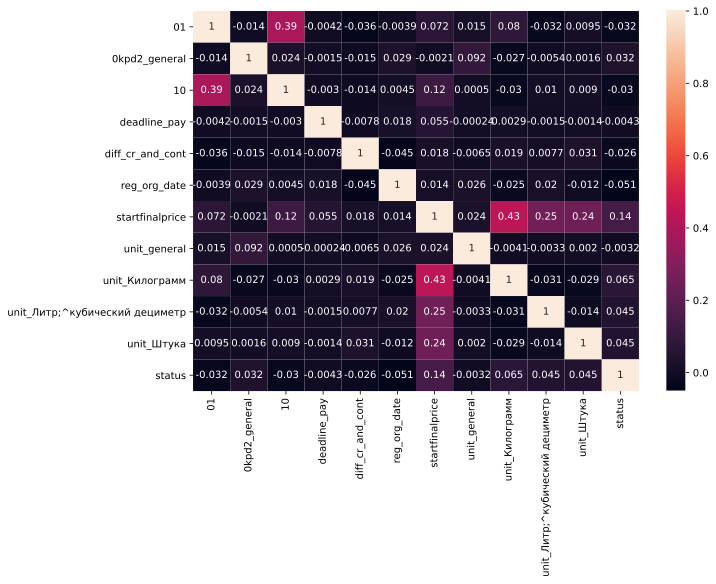

In [19]:
# Матрица корреляции количественных признаков и целевой переменной
features_quantitative_1 = ['01','0kpd2_general', '10', 'deadline_pay', 'diff_cr_and_cont', 
                         'reg_org_date', 'startfinalprice', 'unit_general', 'unit_Килограмм', 
                         'unit_Литр;^кубический дециметр', 'unit_Штука', 'status']
corr_matrix_quantitative = data[features_quantitative_1].corr()
sns.heatmap(corr_matrix_quantitative, annot = True);

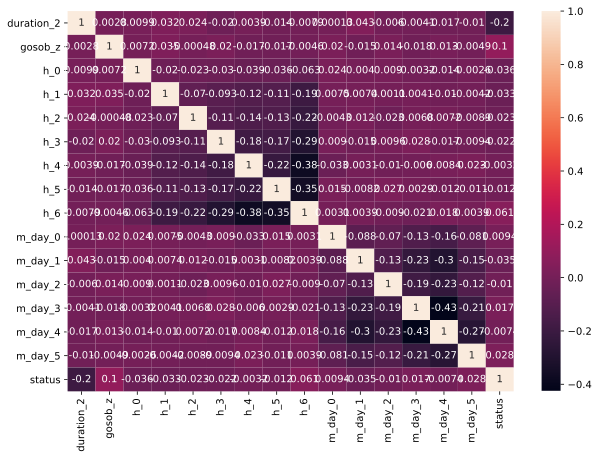

In [20]:
# Матрица корреляции бинарных признаков и целевой переменной - 1
features_binary_1 = ['duration_2', 'gosob_z', 'h_0', 'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6', 
                     'm_day_0', 'm_day_1', 'm_day_2', 'm_day_3', 'm_day_4', 'm_day_5', 'status']
corr_matrix_binary_1 = data[features_binary_1].corr()
sns.heatmap(corr_matrix_binary_1, annot = True);

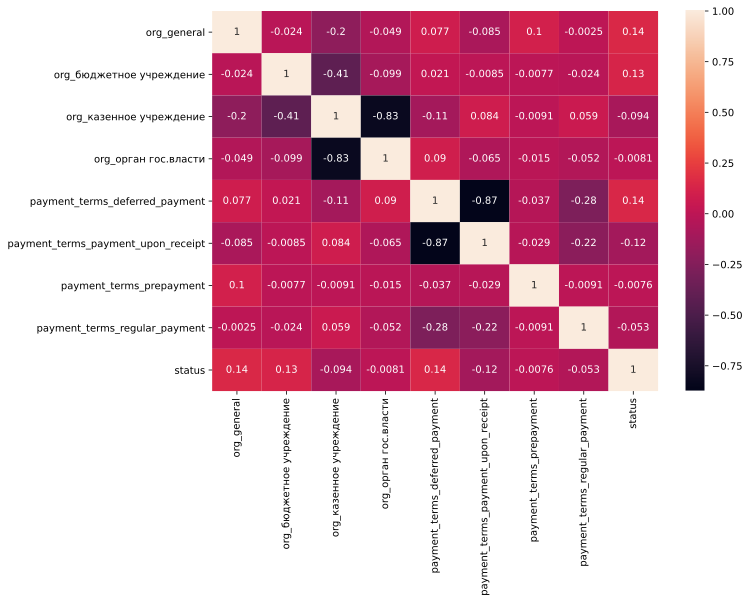

In [21]:
# Матрица корреляции бинарных признаков и целевой переменной - 2
features_binary_2 = ['org_general', 'org_бюджетное учреждение', 'org_казенное учреждение', 'org_орган гос.власти', 
                     'payment_terms_deferred_payment', 'payment_terms_payment_upon_receipt', 'payment_terms_prepayment', 
                     'payment_terms_regular_payment', 'status']
corr_matrix_binary_2 = data[features_binary_2].corr()
sns.heatmap(corr_matrix_binary_2, annot = True);

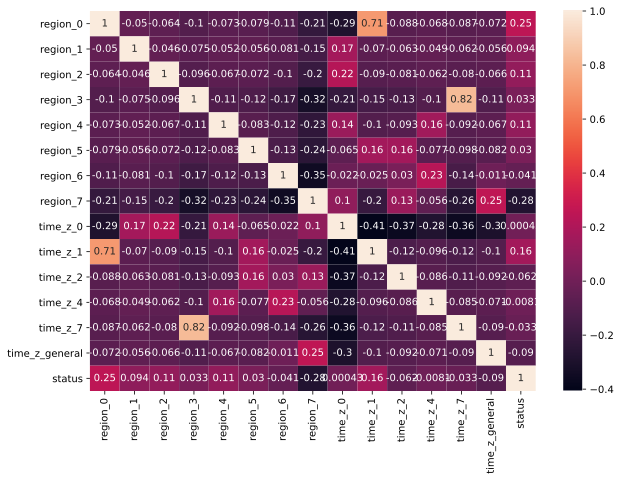

In [22]:
# Матрица корреляции бинарных признаков и целевой переменной - 3
features_binary_3 = ['region_0', 'region_1', 'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7', 
                     'time_z_0', 'time_z_1', 'time_z_2', 'time_z_4', 'time_z_7', 'time_z_general', 'status']
corr_matrix_binary_3 = data[features_binary_3].corr()
sns.heatmap(corr_matrix_binary_3, annot = True);

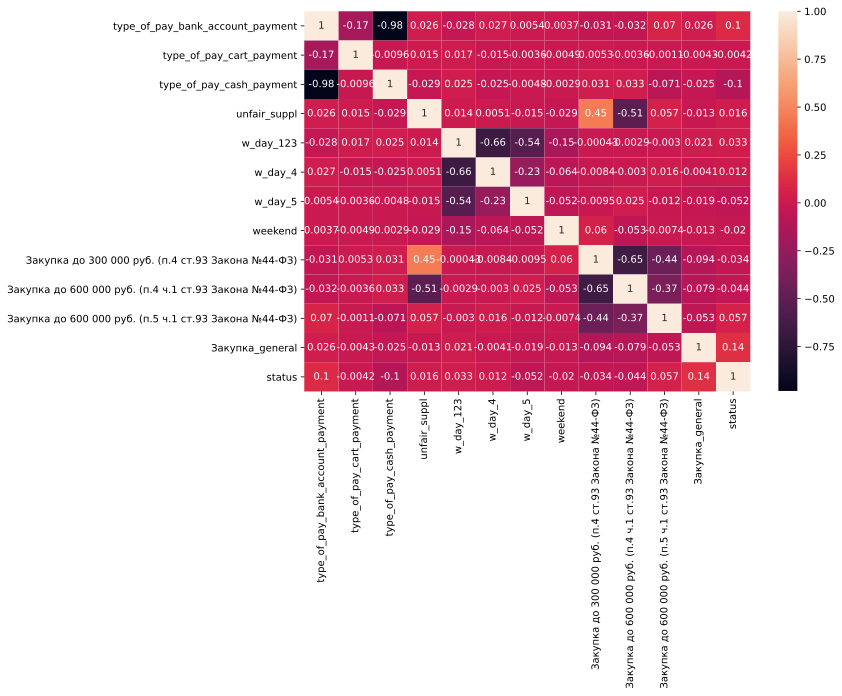

In [23]:
# Матрица корреляции бинарных признаков и целевой переменной - 4
features_binary_4 = ['type_of_pay_bank_account_payment', 'type_of_pay_cart_payment', 'type_of_pay_cash_payment', 
                     'unfair_suppl', 'w_day_123', 'w_day_4', 'w_day_5', 'weekend', 
                     'Закупка до 300 000 руб. (п.4 ст.93 Закона №44-ФЗ)', 
                     'Закупка до 600 000 руб. (п.4 ч.1 ст.93 Закона №44-ФЗ)', 
                     'Закупка до 600 000 руб. (п.5 ч.1 ст.93 Закона №44-ФЗ)', 'Закупка_general', 'status']
corr_matrix_binary_4 = data[features_binary_4].corr()
sns.heatmap(corr_matrix_binary_4, annot = True);

Посмотрим, как признаки связаны с целевым признаком. Построим boxplot-ы, описывающее статистики распределения количественных признаков в двух группах: среди успешных и неуспешных закупок.

In [24]:
features_small = ['01','0kpd2_general', '10', 'deadline_pay', 'diff_cr_and_cont', 
                         'reg_org_date', 'startfinalprice', 'unit_general', 'unit_Килограмм', 
                         'unit_Литр;^кубический дециметр', 'unit_Штука']

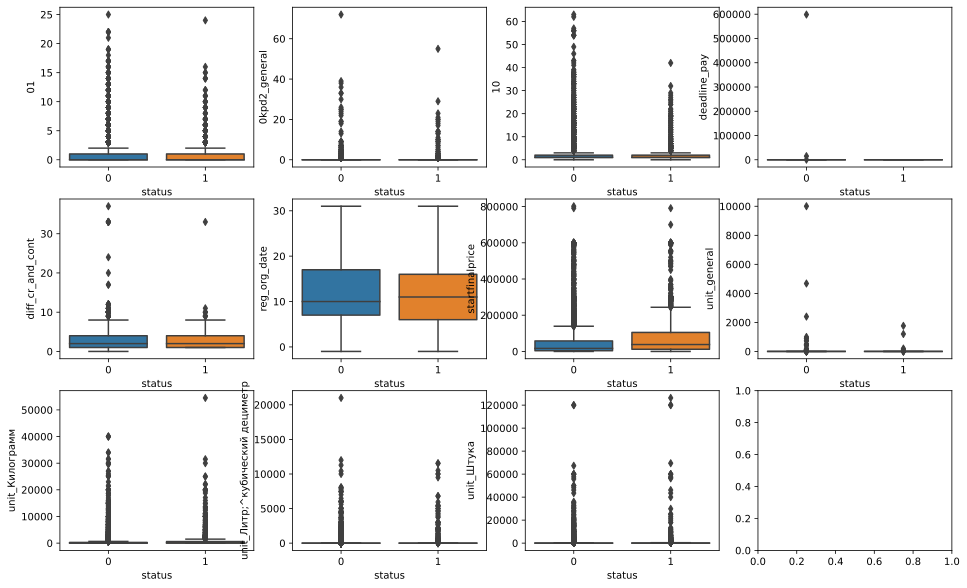

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))


for idx, feat in enumerate(features_small):
    sns.boxplot(x='status', y=feat, data=data, ax=axes[idx // 4, idx % 4])
    axes[idx // 4, idx % 4].set_xlabel('status')
    axes[idx // 4, idx % 4].set_ylabel(feat);

## Выбросы

####  Выбросы по '01'

In [27]:
rcParams['figure.figsize'] = 7, 5

<AxesSubplot:>

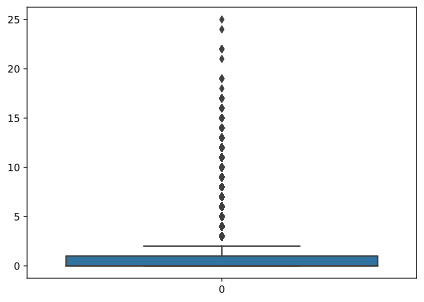

In [28]:
sns.boxplot(data=data['01'])

#### Выбросы по '0kpd2_general'

<AxesSubplot:>

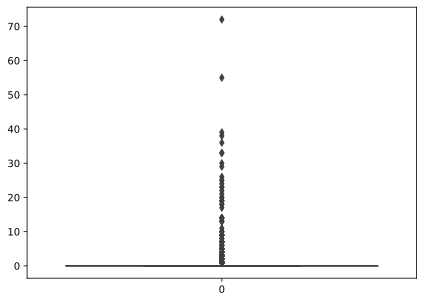

In [29]:
sns.boxplot(data=data['0kpd2_general'])

In [30]:
# data[data['0kpd2_general']>50]['status']
# Хорошие статусы - оставляем

####  Выбросы по '10'

<AxesSubplot:>

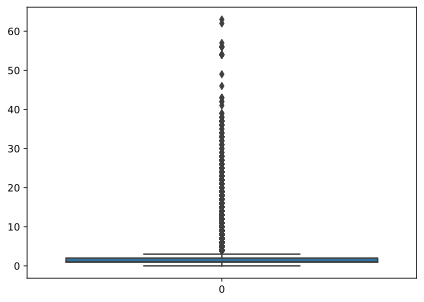

In [31]:
sns.boxplot(data=data['10'])

#### Выбросы по 'deadline_pay' 

<AxesSubplot:>

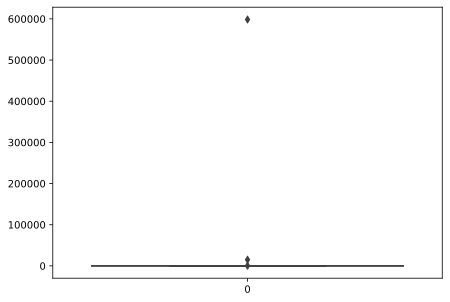

In [32]:
sns.boxplot(data=data['deadline_pay'])

In [33]:
data[data['deadline_pay']>100000]["status"]

9771    0
Name: status, dtype: int64

In [34]:
data.drop(9771, inplace=True)

<AxesSubplot:>

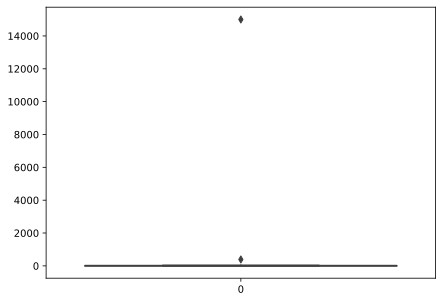

In [35]:
sns.boxplot(data=data['deadline_pay'])

In [36]:
data[data['deadline_pay']>12000]["status"]

6958    0
Name: status, dtype: int64

<AxesSubplot:>

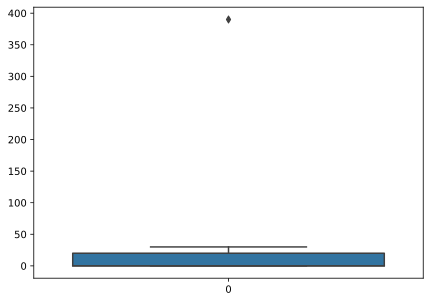

In [37]:
data.drop(6958, inplace=True)
sns.boxplot(data=data['deadline_pay'])

In [38]:
data[data['deadline_pay']>100]["status"]

4431    0
Name: status, dtype: int64

<AxesSubplot:>

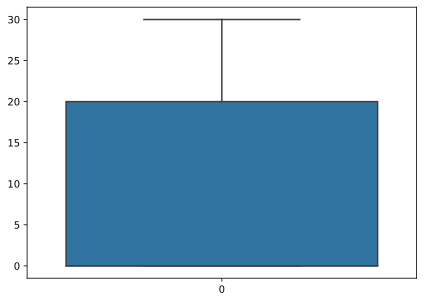

In [39]:
data.drop(4431, inplace=True)
sns.boxplot(data=data['deadline_pay'])

#### Выбросы по 'startfinalprice'

<AxesSubplot:>

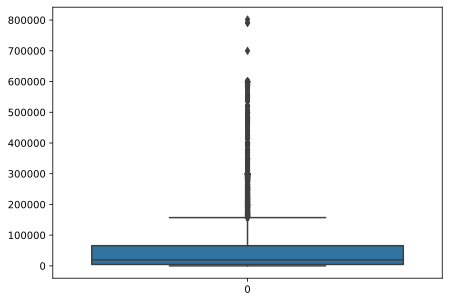

In [40]:
sns.boxplot(data=data['startfinalprice'])

In [41]:
data[data['startfinalprice']>750000]['status'] 
# Есть и хорошие статусы - оставляем

3443    0
3464    1
5194    0
Name: status, dtype: int64

#### Выбросы по 'diff_cr_and_cont'

<AxesSubplot:>

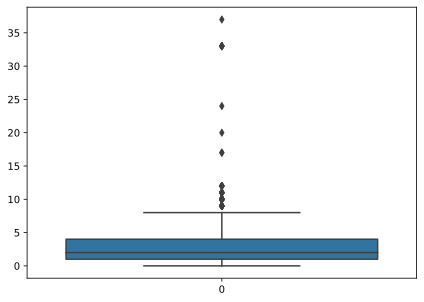

In [42]:
sns.boxplot(data=data['diff_cr_and_cont'])

In [43]:
data['diff_cr_and_cont'].value_counts()

1     4225
3     1781
2     1120
5     1017
4      859
6      638
7      163
10      91
9       20
11      17
8       16
12       8
33       7
17       2
0        2
20       1
37       1
24       1
Name: diff_cr_and_cont, dtype: int64

In [44]:
data[data['diff_cr_and_cont']>30]['status']
# Есть и хорошие статусы - оставляем

809     0
810     1
811     0
812     0
813     0
814     0
815     0
1472    0
Name: status, dtype: int64

####  Выбросы по 'unit_general', 'unit_Килограмм', 'unit_Литр;^кубический дециметр', 'unit_Штука'

<AxesSubplot:>

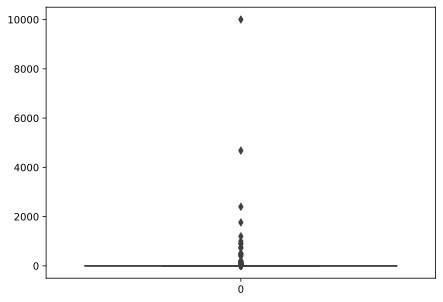

In [45]:
sns.boxplot(data=data['unit_general'])

In [46]:
data[data['unit_general']>4000]['status']

1525    0
2057    0
Name: status, dtype: int64

In [47]:
data.drop(1525, inplace=True)
data.drop(2057, inplace=True)

<AxesSubplot:>

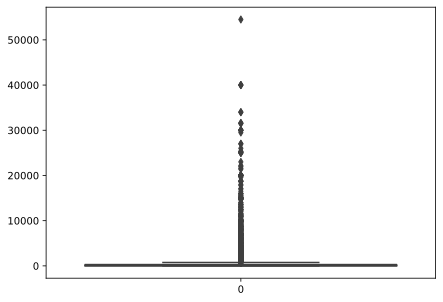

In [48]:
sns.boxplot(data=data['unit_Килограмм'])

In [49]:
data[data['unit_Килограмм']>40000]['status']
# Хороший статус - оставляем

2306    1
Name: status, dtype: int64

<AxesSubplot:>

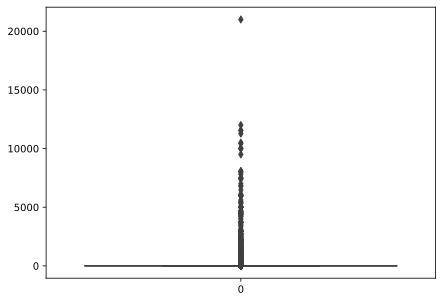

In [50]:
sns.boxplot(data=data['unit_Литр;^кубический дециметр'])

In [51]:
data[data['unit_Литр;^кубический дециметр']>15000]['status']

6409    0
Name: status, dtype: int64

In [52]:
data.drop(6409, inplace=True)

<AxesSubplot:>

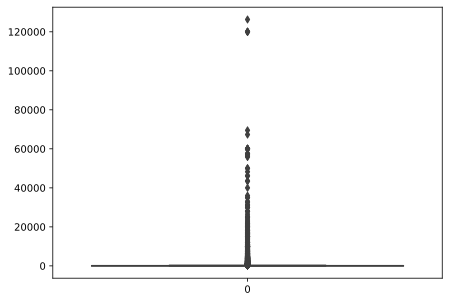

In [53]:
sns.boxplot(data=data['unit_Штука'])

In [54]:
data[data['unit_Штука']>100000]['status']
# Хорошие статусы - оставляем!

2147    1
2639    1
3508    1
3533    0
6032    0
Name: status, dtype: int64

#### Выбросы по 'reg_org_date'

<AxesSubplot:>

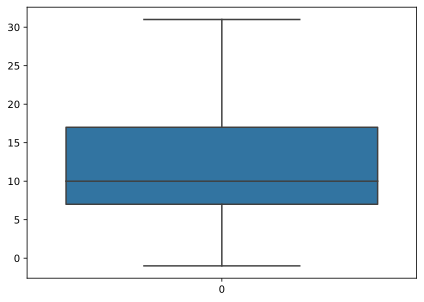

In [55]:
sns.boxplot(data=data['reg_org_date'])

In [56]:
# Сохраним обработанные данные
data.to_json('Coursework_data')